<a href="https://colab.research.google.com/github/sj0054pe/MBTI_Estim/blob/master/5B_BERT_%E6%96%87%E6%9B%B8%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center>BERT Twitter 文書分類 </center>

###<center>参考サイト</center>

###<center>https://qiita.com/takubb/items/fd972f0ac3dba909c293</center>

1. 準備（ライブラリのインストール）
2. データセットの準備
3. データの前処理（BERTが受けとれる形式にデータを整形）
4. 学習済みモデルのロード
5. 訓練（Pre-trainedモデルのファインチューニング）
6. 検証

#0. 作業環境の準備

##0.1. google driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##0.2. カレントディレクトリへ移動

In [ ]:
%cd /content/drive/MyDrive/研究室/研究_M2/src

/content/drive/MyDrive/研究室/研究_M2/src


##0.3. GPUへ接続

In [ ]:
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##0.4. 現在時刻の取得

In [ ]:
import datetime
import pytz

def pull_Datetime():
  DATETIME_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
  #print(DATETIME_now)

  return DATETIME_now

##0.5. 分類モデルの性格指標を指定

この指標をもとに、2クラス分類を行う。

E or I なら
EI指標の分類器を作成する。

In [ ]:
#TYPE_INDEX='EorI_E'
#TYPE_INDEX='NorS_N'
TYPE_INDEX='ForT_F'
#TYPE_INDEX='JorP_J'

##0.6. 学習するデータセットの指定

ツイッターの各投稿に、MBTIの16性格がラベリングされている。


In [ ]:
#INPUT_CSV_v6='./Assets/Assets_Output/Tweet_Datasets/v6S1_forBERT_2021-10-01.csv'
#INPUT_CSV_v6='./Assets/Assets_Output/Tweet_Datasets/v6S2_forBERT_2021-10-03.csv'
#INPUT_CSV_v6='./Assets/Assets_Output/Tweet_Datasets/v6S3_forBERT_2021-10-15.csv'
#INPUT_CSV_v6='./Assets/Assets_Output/Tweet_Datasets/v6S4_forBERT_2021-10-15.csv'
#INPUT_CSV_v6='./Assets/Assets_Output/Tweet_Datasets/v6S5_forBERT_2021-10-23.csv'

#INPUT_CSV_v6='./Assets/Assets_Output/Tweet_Datasets/v6S7_forBERT_2021-11-08_U10sentences.csv' #実質S6

INPUT_CSV_v6='./Assets/Assets_Output/Tweet_Datasets/v6S7_forBERT_2021-11-09_U20R10000.csv'
#INPUT_CSV_v6='./Assets/Assets_Output/Tweet_Datasets/v6S8_forBERT_2021-11-09_U20R10000.csv'

##0.7 学習パラメータを指定

In [ ]:
LEANING_RATE=2e-7
BATCH_SIZE=32
EPOCH=20

In [ ]:
SEASONS='S7ver2P'
WORDS = 20
RAFFLE=10000

SWITCH_CONTINUE ='off'
SWITCH_CONTINUE ='on'

In [ ]:
TERM='%s_L%s_B%s_E%s_W%s_R%s' % (SEASONS, LEANING_RATE, BATCH_SIZE, EPOCH, WORDS, RAFFLE)

print(TERM)

S7ver2P_L2e-07_B32_E20_W20_R10000


#1. 準備 (ライブラリのインストール)

Hugging Face Library 'Transformer' のダウンロード

* transformers
* 最新のNLPモデルを利用できるライブラリ
* BERTの他にもGPT-2, RoBERTa, XLM, DistilBert, XLNet, T5, CTRL...などの最新モデルや100言語以上の学習済みモデル（Pre-trained model）を利用可能

In [ ]:
!pip install transformers

!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3

#参考サイト (https://qiita.com/takubb/items/fd972f0ac3dba909c293) では欠けているライブラリ
!pip install fugashi
!pip install ipadic

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 61 kB 515 kB/s 
     |████████████████████████████████| 895 kB 48.6 MB/s 
     |████████████████████████████████| 596 kB 44.7 MB/s 
     |████████████████████████████████| 3.3 MB 44.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
  swig3.0
Suggested packages:
  aptitude-do

#2. データセットの準備

##2.1.準備したツイートデータをダウンロードする。

In [ ]:
import pandas as pd
df=pd.read_csv('%s' % INPUT_CSV_v6, engine='python')

# データの確認
print(f'データサイズ： {df.shape}')

df[['text', 'tweet_time', 'MBTI_Type','label_EorI','label_NorS','label_ForT','label_JorP']].sample(10)

データサイズ： (10000, 14)


,text,tweet_time,MBTI_Type,label_EorI,label_NorS,label_ForT,label_JorP
5403,【エレキリギリズロック】をサイドチェンジで【狂戦士の魂】にできるデッキ作りたいんだけどなぁ。...,2017-03-15 17:11:50+00:00,ESTP,E,S,T,P
7086,百物語でバックに流れてた紙芝居のような映像も良かったから男士達は出ないナレーションのみで逸話...,2017-12-21 16:25:34+00:00,INFP,I,N,F,P
1205,今朝の電車は空いているので、わざわざ午後に休まなくてもあえて全休にすることでよりプレミアムな...,2017-11-23 23:30:43+00:00,ISFP,I,S,F,P
8847,#シャドバオリジナルデッキ紹介 ・コンボアルベールロイヤル OTKエルフから発案を得た、ロイ...,2017-11-18 23:09:51+00:00,INFP,I,N,F,P
8051,ようやく漫画を読む気力が出てきて、凪のお暇とねねねが大当たりだった,2017-09-06 22:25:38+00:00,INFJ,I,N,F,J
8304,どうなんだろね、手数料まで考えるほど真剣ではなかったわ。でも1〜2万円位なら、試してみたい気...,2017-11-30 02:07:44+00:00,INFP,I,N,F,P
6444,友達とおじさんLINEごっこしてるんだけど、友達、夜職やったことないし周りにおじさん居ないの...,2017-06-27 11:32:03+00:00,INFP,I,N,F,P
1297,いいねした数:0(前日比:+1) いいねされた数:0(前日比:0) フォローした数:0(前日...,2017-12-06 09:21:21+00:00,ISTP,I,S,T,P
8220,デザイナーの僕がいかにしてビデオゲームのUIから「インタラクション・デザイン」を学ぶのか |...,2017-12-18 20:01:51+00:00,ENTJ,E,N,T,J
7573,マウント飛空挺ファルコンで突入よ〜！！！ 魔列車IDと蛮神グラシャラボラスも待ってる！,2017-06-21 21:05:07+00:00,ENTJ,E,N,T,J


In [ ]:
df.dropna(how='any', axis=0, inplace=True)
print(f'データサイズ： {df.shape}')

データサイズ： (10000, 14)


##2.2. 性格指標のone-hot化

In [ ]:
df=pd.get_dummies(df, columns=["label_EorI", "label_NorS", "label_ForT", "label_JorP"], sparse=True)
df[['text', 'tweet_time', 'MBTI_Type','label_EorI_E','label_NorS_N','label_ForT_F','label_JorP_J']]

,text,tweet_time,MBTI_Type,label_EorI_E,label_NorS_N,label_ForT_F,label_JorP_J
0,夏場に買ったスニーカーをずっと履いているんですが流石に北風が生地をスースー通り抜けてくるので...,2017-12-20 01:05:36+00:00,ISFJ,0,0,1,1
1,プレミアムフライデーか…何の関係もないのにイベントだけあるからクソめんどくさいんだよな🙃💥,2017-04-27 23:36:47+00:00,ISFP,0,0,1,0
2,あーここまでやったら怒られるだろうなーっつーぎりぎりを探すのが割と好きって話ーまーそんなかん...,2017-12-03 14:04:54+00:00,ISFJ,0,0,1,1
3,スプラトゥーン2までゼルダをやり込もうと思ってたのに、ラスボス倒したらサブクエやる気一気にな...,2017-06-19 03:51:29+00:00,INTJ,0,1,0,1
4,えぇーΣ(´・ｪ・｀；) 自分の場合、家なくなったら色んなもの保管しておけなくなるから困るな...,2017-12-12 08:23:05+00:00,ISFJ,0,0,1,1
...,...,...,...,...,...,...,...
9995,「走れメロス」は走っていなかった!? 中学生が「メロスの全力を検証」した結果が見事に徒歩 -...,2017-11-30 10:39:48+00:00,INFP,0,1,1,0
9996,自分の名前伏せて晒してもう少し頑張れとか何様やね？ さっきのスコアのも晒したら？,2017-12-03 11:20:02+00:00,INFP,0,1,1,0
9997,VBはどうしても冗長になっちゃいますしねぇ 一応Function(x)でラムダ書けたような…...,2017-10-09 04:46:38+00:00,ENTP,1,1,0,0
9998,奥埜は残留確定とみていいってことかな。というか複数年契約なのかな？ ともかく掻っ攫われなくて...,2017-12-20 23:45:12+00:00,INTP,0,1,0,0


In [ ]:
sentences= df['text'].values #sentences = df.sentence.values
labels= df['label_%s' % TYPE_INDEX].values #labels = df.label.values

In [ ]:
labels 

[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...]
Fill: 0
IntIndex
Indices: array([   0,    1,    2, ..., 9995, 9996, 9999], dtype=int32)

In [ ]:
print(len(sentences))

10000


#3. データの前処理（BERTが受けとれる形式にデータを整形）

BERTでは基本的に学習済みモデルを利用する為、そのモデルが読み込めるフォーマットにデータを変換する必要があります
具体的には、以下の4つ手続きが必要になります

1. BERT Tokenizerを用いて単語分割・IDへ変換
>* 学習済みモデルの作成時と同じtokenizer（形態素解析器）を利用する必要がある
>* 日本語ではMecabやJuman++を利用されることが多い

2. Special tokenの追加
>* 文章の最後に[SEP]という単語する
>* 文章のはじめに[CLS]という単語を追加する（分類問題に利用される）
3. 文章の長さの固定
>* BERTでは全ての文書の長さ（単語の数）を同じにする必要がある（1文章あたりの最大の単語数は512単語）
>* そこで、Padding/Truncatingを用いて固定長に変換する
>* Paddingとは、指定した長さに満たない文章を[Pad]という意味を持たない単語の埋める処理
>* Truncatingとは、指定した長さを超える単語を切り捨てること
4. Attention mask arrayの作成
>* [Padding]を0、それ以外のTokenを1とした配列
>* 一見ややこししそう見えますが、どれもTransformerのライブラリでサポートされているので、簡単に実行できます

また、以下のイメージも参考にモデルの全体像と照らし合わせながら前処理内容をみるとイメージが沸きやすいかもしれません

##3.1. BERT Tokenizerを用いて単語分割・IDへ変換

In [ ]:
## Tokenizerの準備
from transformers import BertJapaneseTokenizer
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

#念の為、確認
## テスト実行
# 元文章
print(' Original: ', sentences[0])
# Tokenizer
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Token-id
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Downloading:   0%|          | 0.00/252k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

 Original:  夏場に買ったスニーカーをずっと履いているんですが流石に北風が生地をスースー通り抜けてくるので、突然欲しくなったムートンブーツを購入。これで冬は乗り切れます。 どやのオシャレ度が20上がった。
Tokenized:  ['夏', '##場', 'に', '買っ', 'た', 'ス', '##ニー', '##カー', 'を', 'ずっと', '履い', 'て', 'いる', 'ん', 'です', 'が', '流', '##石', 'に', '北', '##風', 'が', '生地', 'を', 'スー', '##スー', '通り', '##抜け', 'て', 'くる', 'ので', '、', '突然', '欲', '##しく', 'なっ', 'た', 'ムー', '##トン', '##ブー', '##ツ', 'を', '購入', '。', 'これ', 'で', '冬', 'は', '乗り', '##切れ', 'ます', '。', 'ど', 'や', 'の', 'オシ', '##ャ', '##レ', '度', 'が', '20', '上がっ', 'た', '。']
Token IDs:  [1428, 28570, 7, 9809, 10, 55, 756, 456, 11, 10027, 26909, 16, 33, 1058, 2992, 14, 479, 28922, 7, 210, 29122, 14, 13489, 11, 1496, 26857, 939, 11916, 16, 2501, 947, 6, 6258, 5980, 838, 58, 10, 5490, 3109, 10738, 28659, 11, 2630, 8, 171, 12, 2545, 9, 1815, 11145, 2610, 8, 614, 49, 5, 21160, 28563, 28507, 559, 14, 41, 6656, 10, 8]


##3.2. 次に文章の長さを固定する為に、文章あたりの最大単語数を確認します

ここでは、以下の方法で最大単語数を確認していますが、最大単語数は決め打ちで設定することも可能です

In [ ]:
# print(sentences[15806])

In [ ]:
from tqdm.notebook import tqdm
import numpy as np

# 最大単語数の確認
max_len = []
# 1文づつ処理
len_sentences = len(sentences)
for sent in tqdm(sentences):
    # Tokenizeで分割
    token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(token_words))
# 最大の値を確認
len_max=max(max_len)
#len_q0, len_q25, len_q50, len_q75, len_q100=np.percentile(max_len,  [0, 25, 50, 75, 100])
#len_q75=int(len_q75)
print('最大単語数: ', max(max_len))
print('上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数')

  0%|          | 0/10000 [00:00<?, ?it/s]

最大単語数:  198
上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数


##3.3. Tokenizerと最大単語数の確認がとれたので、全ての文章に一括して処理を行います

tokenizer.encode_plusを利用するとまとめて処理が行えます

In [ ]:
from tqdm.notebook import tqdm

input_ids = []
attention_masks = []

# 1文づつ処理
for sent in tqdm(sentences):
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = len_max,        # 文章の長さを固定（Padding/Trancatinating）#mayo
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )

    # 単語IDを取得    
    input_ids.append(encoded_dict['input_ids'])

    # Attention　maskの取得
    attention_masks.append(encoded_dict['attention_mask'])

# リストに入ったtensorを縦方向（dim=0）へ結合
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

  0%|          | 0/10000 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


##labelをtensor型に変換

labelはpd.get_dummiesでone-hotにしてます

In [ ]:
# tenosor型に変換
labels = torch.tensor(labels)

## BERTの前処理が正常に実行されたか確認

前処理は、

Special tokenの追加、文章の長さの固定、Attention mask arrayの作成

である。

In [ ]:
# 確認
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  夏場に買ったスニーカーをずっと履いているんですが流石に北風が生地をスースー通り抜けてくるので、突然欲しくなったムートンブーツを購入。これで冬は乗り切れます。 どやのオシャレ度が20上がった。
Token IDs: tensor([    2,  1428, 28570,     7,  9809,    10,    55,   756,   456,    11,
        10027, 26909,    16,    33,  1058,  2992,    14,   479, 28922,     7,
          210, 29122,    14, 13489,    11,  1496, 26857,   939, 11916,    16,
         2501,   947,     6,  6258,  5980,   838,    58,    10,  5490,  3109,
        10738, 28659,    11,  2630,     8,   171,    12,  2545,     9,  1815,
        11145,  2610,     8,   614,    49,     5, 21160, 28563, 28507,   559,
           14,    41,  6656,    10,     8,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,   

1つ目の文章の前処理結果です

元々、日本語テキストだった文章がID化されています

Token IDsの最初に単語IDはSpecial tokenの[CLS]を表し、後半の0埋めが[Pad]を示しています



```
Original:  旧式Macで禁断のパワーアップ！最新PCやソフトを一挙にチェック
Token IDs: tensor([    2, 18718,  8653,    12,  1763, 29135,     5, 20734,   679,  6215,
         3794,    49,  1604,    11, 24598,     7,  9398,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])
```



##3.5. データローダの適用とデータの分割

ここまでで、前処理が完了したので、90%を訓練データ、10％をテストデータに分割して、pytorchで学習を行う為に、データローダーへ変換しておきます

データローダーの説明は、pytorchの基本的な操作なので本記事では割愛します（簡単に言うと、データをバッチごとに分割して、学習を上手くやってくれるデータ型です）

In [ ]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# データセットクラスの作成
dataset = TensorDataset(input_ids, attention_masks, labels)

# 90%地点のIDを取得
# train_size = int(0.9 * len(dataset))
# val_size = len(dataset) - train_size
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# データセットを分割
from sklearn.model_selection import train_test_split
train_dataset, val_dataset  = train_test_split(dataset, train_size=(0.7+0.1))
val_dataset, test_dataset  = train_test_split(val_dataset, train_size=(0.7+0.1))

print('訓練データ数：{}'.format(len(train_dataset)))
print('検証データ数:　{} '.format(len(val_dataset )))
print('テストデータ数:　{} '.format(len(test_dataset)))

# データローダーの作成
batch_size = BATCH_SIZE

# 訓練データローダー
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
        )

# 検証データローダー
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )

# 検証データローダー
test_dataloader = DataLoader(
            test_dataset, 
            sampler = SequentialSampler(val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )

訓練データ数：7999
検証データ数:　1600 
テストデータ数:　401 


#4. 学習済みモデルのロード

huggingface transformerのBERTファインチューニングでは以下のタスクをサポートしています
全てBERT Pre-trainedモデルをベースとして学習し、出力層のみそれぞれのタスクに適した構成になっています

* BertModel
* BertForPreTraining
*   BertForMaskedLM
*   BertForNextSentencePrediction
*   BertForSequenceClassification
*   BertForTokenClassification
* BertForQuestionAnswering

公式ドキュメント.

## BertForSequenceClassification

今回は2クラス分類問題なのでBertForSequenceClassificationを利用します

BertForSequenceClassificationは**「BERT学習済みモデルの最後の層に分類用のレイヤー追加したネットワーク構成」**です

データを入力することで、学習済みモデル全体と未学習部分の分類機レイヤーの学習が行われます

デフォルトでは、モデル全体のパラメーターがファインチューニングされますが、学習させるレイヤーの設定変更も可能です

モデルロード時にnum_labelsを変更することで多クラス分類問題へも対応できます

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# BertForSequenceClassification 学習済みモデルのロード
model = BertForSequenceClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese-whole-word-masking", # 日本語Pre trainedモデルの指定
    num_labels = 2, # ラベル数（今回はBinayなので2、数値を増やせばマルチラベルも対応可）
    output_attentions = False, # アテンションベクトルを出力するか
    output_hidden_states = False, # 隠れ層を出力するか
)

# モデルをGPUへ転送
model.cuda()

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

学習済みモデルのロードが完了しました

次にこのモデルを手元のデータに合うようにファインチューニングを行います

#5. 訓練（Pre-trainedモデルのファインチューニング）

モデルのファインチューニングは通常のニューラルネットワークの学習と同様で、損失関数と最適化手法（Optimizer）を指定して、学習ループ（任意のバッチサイズとエポックを指定）を回します

BERTでは損失関数はすでに定義されているので、ハイパーパラメーターとして、最適化手法とバッチサイズをエポック数だけ指定します

ここでは、論文（BERT paper, Appendix A.3）に従って、最適化関数はAdamW（Adam Weight Decay fix）を利用し、ハイパーパラメーターは下記のように設定します

Batch size: 32
Learning rate: 2e-5
Epochs: 4

https://qiita.com/takubb/items/fd972f0ac3dba909c293

In [ ]:
# 最適化手法の設定
optimizer = AdamW(model.parameters(), lr=LEANING_RATE)

# 訓練パートの定義
def train(model):
    model.train() # 訓練モードで実行
    train_loss = 0
    count_batch=0
    for batch in train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        logits= outputs.logits
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
        count_batch+=1
    train_loss = train_loss / count_batch #https://yoshinashigoto-blog.herokuapp.com/detail/30/
    return train_loss

# テストパートの定義
def validation(model):
    model.eval()# 訓練モードをオフ
    valid_loss = 0
    count_batch=0
    with torch.no_grad(): # 勾配を計算しない
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():
                    outputs_valid = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
                    loss = outputs_valid.loss
                    logits= outputs_valid.logits
            valid_loss += loss.item()
            count_batch+=1
    valid_loss= valid_loss/count_batch
    return valid_loss

学習に必要な関数が定義できたので、学習を行う

In [ ]:
import pandas as pd
import numpy as np

try:
  df_performance=pd.read_csv('./loss_%s_%s.csv' % (TERM, TYPE_INDEX), header=0)
  print('./loss_%s_%s.csv を 読み込みました。' % (TERM, TYPE_INDEX))
except:
  list_performance=[]
  df_performance = pd.DataFrame(index=range(EPOCH), columns=['train_loss', 'valid_loss'])
  df_performance.index.name="epoch"
  df_performance.fillna(np.nan, inplace=True)
  df_performance.to_csv('./%s_%s.csv' % (TERM, TYPE_INDEX))
  print('./loss_%s_%s.csv を 作成しました。' % (TERM, TYPE_INDEX))

./loss_S7ver2P_L2e-07_B32_E20_W20_R10000_ForT_F.csv を 読み込みました。


In [ ]:
df_performance

,epoch,train_loss,valid_loss
0,0,0.638438,0.631633
1,1,0.631242,0.628814
2,2,0.628485,0.627432
3,3,0.626135,0.626293
4,4,0.627194,0.625207
5,5,0.624895,0.624225
6,6,0.623270,0.623267
7,7,0.621919,0.622458
8,8,0.621476,0.621685
9,9,0.618520,0.621059


In [ ]:
import time
start = time.time()

# 学習の実行
max_epoch = EPOCH
list_train_loss=df_performance['train_loss'].values.tolist()
list_valid_loss=df_performance['valid_loss'].values.tolist()
epoch=0

#学習途中の状態を読み込む。
#SWITCH_CONTINUE='on'
if SWITCH_CONTINUE=='on':
  print('continue previous training...')
  print()
  checkpoint = torch.load("./model_%s_%s.tar" % (TERM, TYPE_INDEX))
  model.load_state_dict(checkpoint["model_state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
  epoch = checkpoint["epoch"]
  list_train_loss=df_performance['train_loss'].values.tolist()
  list_valid_loss=df_performance['valid_loss'].values.tolist()
  SWITCH_CONTINUE = 'off'
 
for epoch in range(epoch, max_epoch):
    print("%s epoch" % (epoch))

    train_ = train(model)
    
    # 学習途中の状態を保存する。 #https://pystyle.info/pytorch-save-and-load-model/
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
         },
         "model_%s_%s.tar" % (TERM, TYPE_INDEX),
    )

    valid_ = validation(model)

    list_train_loss[epoch]=train_
    list_valid_loss[epoch]=valid_
    print(list_train_loss)
    print(list_valid_loss)

    #print(df_performance.columns)
    df_performance.loc[epoch, 'train_loss'] = list_train_loss[epoch]
    df_performance.loc[epoch, 'valid_loss'] = list_valid_loss[epoch]
    # df_performance['train_loss']=list_train_loss[epoch]
    # df_performance['valid_loss']=list_val_loss[epoch]
    print(list_train_loss[epoch], list_train_loss[epoch])
    print(df_performance.loc[epoch]['train_loss'], df_performance.loc[epoch]['valid_loss'])
    df_performance.to_csv('./loss_%s_%s.csv' % (TERM, TYPE_INDEX))
    print(df_performance)
    print(' Added to ./loss_%s_%s.csv.' % (TERM, TYPE_INDEX))
    print("train loss : ", df_performance.loc[epoch]['train_loss'], "   |   valid_loss : ", df_performance.loc[epoch]['valid_loss'])

    elapsed_time = time.time() - start
    print(" %s epoch  :  %s [sec] → %s" % (epoch, elapsed_time, pull_Datetime()))
    print()
print("終了時間 : %s [sec] → %s" % (elapsed_time, pull_Datetime()))

continue previous training...

10 epoch
[0.6384381544589997, 0.6312418087720871, 0.6284851464033127, 0.6261353279352189, 0.6271939889192581, 0.6248951098918915, 0.6232696818113327, 0.6219187021255493, 0.6214761892557145, 0.6185195095539093, 0.6149506675004959, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[0.6316333055496216, 0.6288135010004043, 0.6274323946237564, 0.6262928926944733, 0.6252068555355073, 0.624225086569786, 0.6232667541503907, 0.6224578338861465, 0.6216851145029068, 0.6210594922304153, 0.6302393519878388, nan, nan, nan, nan, nan, nan, nan, nan, nan]
0.6149506675004959 0.6149506675004959
0.6149506675004959 0.6302393519878388
    epoch  train_loss  valid_loss
0       0    0.638438    0.631633
1       1    0.631242    0.628814
2       2    0.628485    0.627432
3       3    0.626135    0.626293
4       4    0.627194    0.625207
5       5    0.624895    0.624225
6       6    0.623270    0.623267
7       7    0.621919    0.622458
8       8    0.621476    0.621685
9       9    

In [ ]:
print('list_train_loss : ', list_train_loss)
print('list_valid_loss : ', list_valid_loss)

list_train_loss :  [0.6384381544589997, 0.6312418087720871, 0.6284851464033127, 0.6261353279352189, 0.6271939889192581, 0.6248951098918915, 0.6232696818113327, 0.6219187021255493, 0.6214761892557145, 0.6185195095539093, 0.6149506675004959, 0.6145857492685318, 0.6136652102470398, 0.6113741809129715, 0.6094896951913834, 0.6100989453792572, 0.6086575207710266, 0.6075606290102005, 0.6054950337409973, 0.6036053630113601]
list_valid_loss :  [0.6316333055496216, 0.6288135010004043, 0.6274323946237564, 0.6262928926944733, 0.6252068555355073, 0.624225086569786, 0.6232667541503907, 0.6224578338861465, 0.6216851145029068, 0.6210594922304153, 0.6302393519878388, 0.6293229949474335, 0.6288899779319763, 0.6278674006462097, 0.6272252607345581, 0.6270933485031128, 0.6269723343849182, 0.6261479473114013, 0.6266433954238891, 0.6270082330703736]


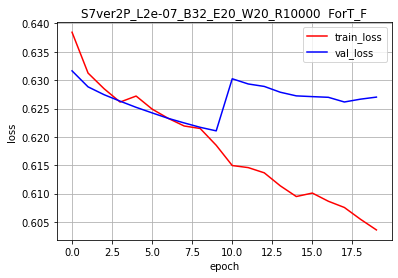

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot learning curve
plt.figure()
epoch=19
plt.plot(list(range(epoch+1)), list_train_loss, 'r-', label='train_loss')
plt.plot(list(range(epoch+1)), list_valid_loss, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.title('%s  %s' % (TERM, TYPE_INDEX))

plt.savefig('./loss_%s_%s.jpeg' % (TERM, TYPE_INDEX))

#6. 検証

In [ ]:
# 検証方法の確認（1バッチ分で計算ロジックに確認）

model.eval()# 訓練モードをオフ
try:
    for idx, batch in enumerate(test_dataloader):
        print(idx)
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():   
            # 学習済みモデルによる予測結果をpredsで取得     
            preds = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)
except:
    pass

0
1
2
3
4
5
6
7
8
9
10
11


以下の様な結果が出力されます
この確率の様な値（厳密には、この値ををソフトマックス関数に入力すると確率になる）が大きい方のラベルをモデルは分類結果とし予測としています

In [ ]:
## 予測結果の確認
print(f'出力:{preds}')

出力:SequenceClassifierOutput(loss=None, logits=tensor([[-0.1786,  0.2770],
        [-0.2098,  0.2366],
        [-0.3110,  0.0775],
        [-0.6311,  1.3246],
        [-0.2321,  0.0590],
        [-0.3814,  0.7582],
        [-0.6361,  1.1163],
        [-0.3486,  0.2002],
        [-0.2059,  0.2187],
        [-0.2922,  0.3426],
        [-0.0956, -0.0119],
        [ 0.0060,  0.1704],
        [-0.4563,  0.6602],
        [-0.4543,  0.3162],
        [-0.7861,  1.0820],
        [-0.4755,  0.7197],
        [-0.1371,  0.2455],
        [-0.3017,  0.5172],
        [-0.4339,  0.3247],
        [-0.1989,  0.2446],
        [-0.4731,  0.6374],
        [-0.3644,  0.5820],
        [-0.0274, -0.0193],
        [-0.6053,  0.9375],
        [-0.4689,  0.4734],
        [-0.1763,  0.3268],
        [-0.5218,  1.1146],
        [-0.3077,  0.2882],
        [-0.5693,  0.8408],
        [-0.6714,  0.4665],
        [-0.4512,  0.1763],
        [-0.2951,  0.2312]], device='cuda:0'), hidden_states=None, attentions=None)




```
出力:(tensor([[-5.0226,  5.0193],
        [-5.0390,  4.9736],
        [ 4.7941, -4.7459],
        [-4.9395,  4.6827], device='cuda:0'),)
```



左からラベルの[0, 1]に対応しており、1つ目のデータであれば、右側の値が大きいのでモデルはラベル1を予測している

In [ ]:
# 比較しやすい様にpd.dataframeへ整形
import numpy as np
import pandas as pd
# pd.dataframeへ変換（GPUに乗っているTensorはgpu->cpu->numpy->dataframeと変換）
logits_df = pd.DataFrame(preds[0].cpu().numpy(), columns=['logit_0', 'logit_1'])
## np.argmaxで大き方の値を取得
pred_df = pd.DataFrame(np.argmax(preds[0].cpu().numpy(), axis=1), columns=['pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])

accuracy_df = pd.concat([logits_df, pred_df, label_df], axis=1)

accuracy_df.head()

accuracy_df.to_csv('./results_%s_%s.csv' % (TERM, TYPE_INDEX))
print(('./results_%s_%s.csv' % (TERM, TYPE_INDEX)))

./results_S7ver2P_L2e-07_B32_E20_W20_R10000_ForT_F.csv


In [ ]:
accuracy_df

,logit_0,logit_1,pred_label,true_label
0,-0.178602,0.277041,1,0
1,-0.209785,0.236646,1,1
2,-0.311030,0.077467,1,0
3,-0.631101,1.324626,1,1
4,-0.232145,0.058987,1,0
5,-0.381399,0.758245,1,1
6,-0.636136,1.116294,1,1
7,-0.348566,0.200215,1,1
8,-0.205922,0.218694,1,1
9,-0.292229,0.342593,1,1


In [ ]:
accuracy_df['answer'] = (accuracy_df['pred_label'] == accuracy_df['true_label'])
list_answer=accuracy_df['answer'].to_list()
count_true=list_answer.count(True)
print(list_answer)
print(count_true)
print('accuracy : ',  float(count_true / len(list_answer))*100)

[False, True, False, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, True, True, False, False, True, True, True, True, False]
24
accuracy :  75.0


In [ ]:
import numpy as np

print(('./results_%s_%s.csv' % (TERM, TYPE_INDEX)))

test_df=accuracy_df
list_predLabel=test_df['pred_label'].to_list()
list_trureLabel = test_df['true_label'].to_list()

from sklearn.metrics import accuracy_score
print(accuracy_score(list_trureLabel,  list_predLabel))

from sklearn.metrics import precision_score
print(precision_score(list_trureLabel,  list_predLabel)) #適合率　#適合率（precision）は、陽性と予測されたサンプルのうち正解したサンプルの割合。

from sklearn.metrics import recall_score
print(recall_score(list_trureLabel,  list_predLabel)) #再現率 #再現率（recall）は実際に陽性のサンプルのうち正解したサンプルの割合。


list_predScore = test_df['logit_1']
def sigmoid(x):
    return 1/(1 + np.exp(-x))

list_predScore2=[]
list_predScore2.clear()
for idx, element in enumerate(list_predScore):
  list_predScore2.append(sigmoid(list_predScore[idx]))

print(list_trureLabel)
print(list_predScore2)

import numpy as np
from sklearn.metrics import roc_auc_score
roc_auc_score(list_trureLabel,  list_predScore2)

./results_S7ver2P_L2e-07_B32_E20_W20_R10000_ForT_F.csv
0.75
0.75
1.0
[0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
[0.5688206100477576, 0.5588868511043927, 0.5193570939111342, 0.7899503338717863, 0.5147423445065991, 0.6809725617700058, 0.7533006317572721, 0.5498872625993013, 0.5544567360602789, 0.5848203207403785, 0.4970288856659272, 0.5425068200510552, 0.6592999352065484, 0.5783983794159709, 0.7468778452871611, 0.6725347915622965, 0.5610714215962863, 0.6264988147946666, 0.5804767127414918, 0.5608494796255004, 0.6541615045747046, 0.6415291821470505, 0.4951847540430073, 0.7185921052899276, 0.6161775126640349, 0.5809907348806181, 0.7529918665178984, 0.5715480003010153, 0.6986432121233296, 0.6145490236371405, 0.5439648048894664, 0.5575489484088259]


0.6041666666666667

In [ ]:
pred_df.values

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

上記の様に予測ラベルと正解ラベルを取得して、dataframeへ保存することができました

あとは、シンプルに正解率を計算するなり、sklearnを用いて混合行列を作成するなり、好きな様に分類モデルの評価を行うことができる。